In [4]:
# import 

from collections import defaultdict, OrderedDict, Counter
from datetime import datetime

from dateutil.relativedelta import relativedelta
import glob
from itertools import product, combinations
import matplotlib.pyplot as plt
import numpy    as np
#import networkx as nx
from operator import itemgetter
import pandas   as pd
import rdflib as rdflib
import re
from scipy.signal import convolve2d
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from SPARQLWrapper import SPARQLWrapper, JSON, POST, TURTLE
import sys
from rdflib.namespace import XSD, Namespace
from rdflib.term import URIRef

import IPython
import pprint
pp = pprint.PrettyPrinter(indent=4)



from constants import *
from helpers import *

import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy    as np

#set_theme() 
sns.set_theme(style="white",palette="PuOr_r")

In [5]:
end_year=2020
start_year=1971
period_length=5
year_range = end_year - start_year
modulo = year_range % period_length
if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - modulo
final_end = end_year + 1

starts = np.arange(start_year, final_start, period_length).tolist()
tuples = [(start, start+period_length) for start in starts]
# We'll add the last period calculated earlier
tuples.append(tuple([final_start, final_end]))
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')

In [6]:
def to_df(reslist, sort_column):
    my_df=pd.DataFrame(reslist).sort_values(by=sort_column)
    if "year" in my_df.columns:
        my_df["year"]=pd.to_numeric(my_df["year"])
    return my_df


# add period function
def add_period(df_fo, columnname="year"):
    df_fo['period'] = pd.cut(df_fo[columnname], bins=bins, include_lowest=True, precision=0)
    df_fo['period'] = df_fo['period'].astype("str")

    df_fo["period"]=df_fo["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
    return df_fo

# decade function
def add_decade(df_fi, columname="year"):
    df_fi["decade"]=(df_fi["year"]-1)- ((df_fi["year"]-1)%10)
    
    return df_fi

In [21]:

def simpson_slice(df_slice):
  
  return df_slice**2#.sum()

In [7]:
# datasets

df_fi=pd.read_csv("../../data/df_fi_all.csv", sep="\t", index_col=0)
df_fo=pd.read_csv("../../data/df_fo_all.csv", sep="\t", index_col=0)
df_fo2=pd.read_csv("../../data/df_fo_all2.csv", sep="\t", index_col=0)

# table 4.2

In [14]:


df_fo2=add_period(df_fo2)

df_fo2.groupby(["period"])[["novel","author","lang","nat"]].nunique()

,novel,author,lang,nat
period,,,,
1971,1088,616,25,42
1976,1366,750,31,56
1981,1293,827,26,55
1986,1466,946,29,68
1991,1360,819,33,57
1996,1736,901,29,65
2001,2245,1078,30,64
2006,2289,1235,34,73
2011,2245,1214,32,69


## simpson

In [18]:

# overall simpson (without gender)

total_count=df_fo2.groupby("year")["novel"].nunique().reset_index()
total_count
lang_count=df_fo2.groupby(["year","lang"])["novel"].nunique().reset_index()
nat_count=df_fo2.groupby(["year","nat"])["novel"].nunique().reset_index()

In [19]:
df_langs=total_count.merge(lang_count, on="year", suffixes=["","_lang"])
df_langs["yrel"]=df_langs["novel_lang"]/df_langs["novel"]

In [22]:
# simpson langs

simpson_df=df_langs.drop_duplicates(["year","novel_lang","lang"]).groupby(["year","lang"]).yrel.agg(simpson_slice).reset_index(name="simpson")
display(simpson_df.head())
simpson_t=simpson_df.groupby(["year"]).simpson.sum().apply(lambda x: round(1-x,3)).reset_index()

simpson_t["year"]=pd.to_numeric(simpson_t["year"])
simpson_t

,year,lang,simpson
0,1971,http://lexvo.org/id/iso639-3/ces,0.000027
1,1971,http://lexvo.org/id/iso639-3/dan,0.000107
2,1971,http://lexvo.org/id/iso639-3/deu,0.000671
3,1971,http://lexvo.org/id/iso639-3/eng,0.355043
4,1971,http://lexvo.org/id/iso639-3/est,0.000027


,year,simpson
0,1971,0.608
1,1972,0.580
2,1973,0.601
3,1974,0.629
4,1975,0.644
5,1976,0.643
6,1977,0.629
7,1978,0.619
8,1979,0.625
9,1980,0.608


In [35]:
simpson_t=add_period(simpson_t)
simpson_t=add_decade(simpson_t)
simpson_t.groupby("period").mean()

,year,simpson,decade
period,,,
1971,1973.0,0.6124,1970.0
1976,1978.0,0.6248,1970.0
1981,1983.0,0.5522,1980.0
1986,1988.0,0.4628,1980.0
1991,1993.0,0.4560,1990.0
1996,1998.0,0.4680,1990.0
2001,2003.0,0.5142,2000.0
2006,2008.0,0.5306,2000.0
2011,2013.0,0.5400,2010.0


In [23]:
#simpson_t.to_csv("../../data/simpson_lang.csv",sep="\t")

In [24]:
df_nats=total_count.merge(nat_count, on="year", suffixes=["","_nat"])
df_nats["yrel"]=df_nats["novel_nat"]/df_nats["novel"]
df_nats

,year,novel,nat,novel_nat,yrel
0,1971,193,http://seco.tkk.fi/onto/toimo/nationalities/Czech,1,0.005181
1,1971,193,http://seco.tkk.fi/saha3/ue4725a75-e6f5-4550-b...,1,0.005181
2,1971,193,http://www.yso.fi/onto/koko/p12201,3,0.015544
3,1971,193,http://www.yso.fi/onto/koko/p14632,3,0.015544
4,1971,193,http://www.yso.fi/onto/koko/p16897,25,0.129534
...,...,...,...,...,...
1790,2020,494,http://www.yso.fi/onto/koko/p8327,4,0.008097
1791,2020,494,http://www.yso.fi/onto/koko/p85987,1,0.002024
1792,2020,494,http://www.yso.fi/onto/koko/p9113,13,0.026316
1793,2020,494,http://www.yso.fi/onto/koko/p9135,6,0.012146


In [25]:
simpson_df=df_nats.drop_duplicates(["year","novel_nat","nat"]).groupby(["year","nat"]).yrel.agg(simpson_slice).reset_index(name="simpson")
display(simpson_df.head())
simpson_t_n=simpson_df.groupby(["year"]).simpson.sum().apply(lambda x: round(1-x,3)).reset_index()

simpson_t_n["year"]=pd.to_numeric(simpson_t_n["year"])
simpson_t_n.head()

,year,nat,simpson
0,1971,http://seco.tkk.fi/onto/toimo/nationalities/Czech,0.000027
1,1971,http://seco.tkk.fi/saha3/ue4725a75-e6f5-4550-b...,0.000027
2,1971,http://www.yso.fi/onto/koko/p12201,0.000242
3,1971,http://www.yso.fi/onto/koko/p14632,0.000242
4,1971,http://www.yso.fi/onto/koko/p16897,0.016779


,year,simpson
0,1971,0.847
1,1972,0.831
2,1973,0.837
3,1974,0.855
4,1975,0.854
5,1976,0.860
6,1977,0.849
7,1978,0.852
8,1979,0.852
9,1980,0.844


In [26]:
#simpson_t_n.to_csv("../../data/simpson_nat.csv",sep="\t")

In [30]:
simpson_t_n=add_period(simpson_t_n)
simpson_t_n.groupby("period").mean()

,year,simpson,decade
period,,,
1971,1973.0,0.8448,1970.0
1976,1978.0,0.8514,1970.0
1981,1983.0,0.8266,1980.0
1986,1988.0,0.8012,1980.0
1991,1993.0,0.7612,1990.0
1996,1998.0,0.7518,1990.0
2001,2003.0,0.8024,2000.0
2006,2008.0,0.8084,2000.0
2011,2013.0,0.8070,2010.0


## t test

In [56]:
import statsmodels.api as sm
from scipy import stats
import pandas
from scipy.stats import ttest_1samp,ttest_ind

# statistical test, languages

testdf=simpson_t[simpson_t["decade"].isin([1990,2010])]
test90=simpson_t[simpson_t["decade"].isin([1990])]
test10=simpson_t[simpson_t["decade"].isin([2010])]

# print mean
print(simpson_t.groupby("decade")["simpson"].mean())
print(simpson_t.groupby("decade")["simpson"].std())

decade
1970    0.6186
1980    0.5075
1990    0.4620
2000    0.5224
2010    0.5826
Name: simpson, dtype: float64
decade
1970    0.019783
1980    0.058281
1990    0.024712
2000    0.027015
2010    0.064201
Name: simpson, dtype: float64


Ttest_1sampResult(statistic=59.120740935255746, pvalue=5.710091523449449e-13)
Ttest_1sampResult(statistic=28.696296575755458, pvalue=3.6908335718039504e-10)
LeveneResult(statistic=1.9408170316381779, pvalue=0.1805472975745671)


/tmp/ipykernel_8709/380735615.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


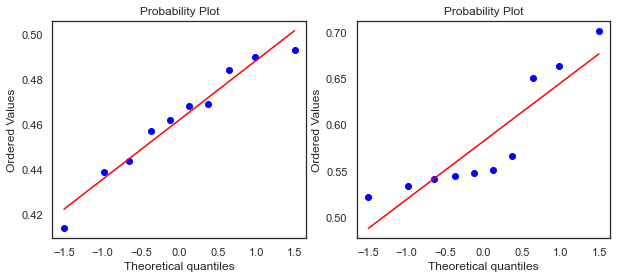

In [57]:
# assumption checking
print(ttest_1samp(test90['simpson'], 0) )
print(ttest_1samp(test10['simpson'], 0) )
print(stats.levene(test90['simpson'], test10["simpson"]) ) # should not be significant and is not

fig, ax= plt.subplots(1,2,figsize=(10,4))

stats.probplot(test90['simpson'], dist="norm", plot= ax[0])
stats.probplot(test10['simpson'], dist="norm", plot= ax[1]) # this looks bad...
fig.show()

In [58]:
# it is normally distributed!
sampling_difference = test90['simpson'].values - \
                      test10['simpson'].values

print(stats.shapiro(sampling_difference))


ShapiroResult(statistic=0.9582840800285339, pvalue=0.7661434412002563)


In [59]:
# t-test
mean90 = testdf[testdf['decade'] == 1990]['simpson']
mean2010 = testdf[testdf['decade'] == 2010]['simpson']
ttest_ind(mean90, mean2010)  

Ttest_indResult(statistic=-5.543735564590458, pvalue=2.9070647276698458e-05)

In [60]:
import researchpy as rp
rp.ttest(group1= mean90, group1_name= "90",
         group2= mean2010, group2_name= "10")

/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/researchpy/ttest.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


(   Variable     N    Mean        SD        SE  95% Conf.  Interval
 0        90  10.0  0.4620  0.024712  0.007815   0.444322  0.479678
 1        10  10.0  0.5826  0.064201  0.020302   0.536673  0.628527
 2  combined  20.0  0.5223  0.077905  0.017420   0.485839  0.558761,
           Independent t-test  results
 0    Difference (90 - 10) =   -0.1206
 1      Degrees of freedom =   18.0000
 2                       t =   -5.5437
 3   Two side test p value =    0.0000
 4  Difference < 0 p value =    0.0000
 5  Difference > 0 p value =    1.0000
 6               Cohen's d =   -2.4792
 7               Hedge's g =   -2.3745
 8           Glass's delta =   -4.8803
 9             Pearson's r =    0.7941)

In [49]:
# nationalities
testdf=simpson_t_n[simpson_t_n["decade"].isin([1990,2010])]
test90=simpson_t_n[simpson_t_n["decade"].isin([1990])]
test10=simpson_t_n[simpson_t_n["decade"].isin([2010])]

# print mean
print(simpson_t_n.groupby("decade")["simpson"].mean())
print(simpson_t_n.groupby("decade")["simpson"].std())

decade
1970    0.8481
1980    0.8139
1990    0.7565
2000    0.8054
2010    0.8226
Name: simpson, dtype: float64
decade
1970    0.008749
1980    0.019215
1990    0.019045
2000    0.012963
2010    0.022147
Name: simpson, dtype: float64


Ttest_1sampResult(statistic=125.60931597766448, pvalue=6.526209472514053e-16)
Ttest_1sampResult(statistic=117.45570563936765, pvalue=1.1935623174600294e-15)
LeveneResult(statistic=0.11879341864716209, pvalue=0.7343411530684332)


/tmp/ipykernel_8709/380735615.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


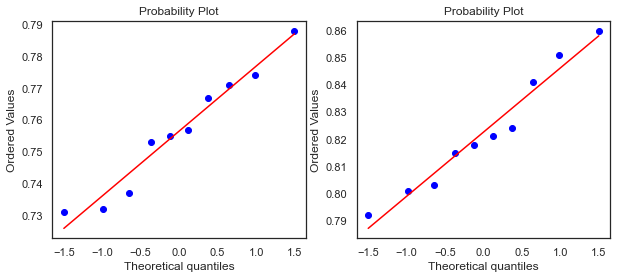

In [50]:
# assumption checking
print(ttest_1samp(test90['simpson'], 0) )
print(ttest_1samp(test10['simpson'], 0) )
print(stats.levene(test90['simpson'], test10["simpson"]) ) # should not be significant and is not

fig, ax= plt.subplots(1,2,figsize=(10,4))

stats.probplot(test90['simpson'], dist="norm", plot= ax[0])
stats.probplot(test10['simpson'], dist="norm", plot= ax[1]) # this looks bad...
fig.show()

In [53]:
# shapiro

In [51]:
# it is normally distributed!
sampling_difference = test90['simpson'].values - \
                      test10['simpson'].values

print(stats.shapiro(sampling_difference))


ShapiroResult(statistic=0.9169024229049683, pvalue=0.3318428695201874)


In [54]:
mean90 = testdf[testdf['decade'] == 1990]['simpson']
mean2010 = testdf[testdf['decade'] == 2010]['simpson']

rp.ttest(group1= mean90, group1_name= "90",
         group2= mean2010, group2_name= "10")

/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/researchpy/ttest.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


(   Variable     N     Mean        SD        SE  95% Conf.  Interval
 0        90  10.0  0.75650  0.019045  0.006023   0.742876  0.770124
 1        10  10.0  0.82260  0.022147  0.007003   0.806757  0.838443
 2  combined  20.0  0.78955  0.039420  0.008815   0.771101  0.807999,
           Independent t-test  results
 0    Difference (90 - 10) =   -0.0661
 1      Degrees of freedom =   18.0000
 2                       t =   -7.1560
 3   Two side test p value =    0.0000
 4  Difference < 0 p value =    0.0000
 5  Difference > 0 p value =    1.0000
 6               Cohen's d =   -3.2003
 7               Hedge's g =   -3.0651
 8           Glass's delta =   -3.4707
 9             Pearson's r =    0.8602)

# gender balance

In [8]:
df_fo2=add_decade(df_fo2)

In [9]:
df_fo2.groupby(["decade","gender"])["novel"].nunique()

decade  gender                                
1970    http://www.yso.fi/onto/kaunokki#female     798
        http://www.yso.fi/onto/kaunokki#male      1549
        unk                                        121
1980    http://www.yso.fi/onto/kaunokki#female    1062
        http://www.yso.fi/onto/kaunokki#male      1610
        unk                                         94
1990    http://www.yso.fi/onto/kaunokki#female    1343
        http://www.yso.fi/onto/kaunokki#male      1726
        unk                                         77
2000    http://www.yso.fi/onto/kaunokki#female    2206
        http://www.yso.fi/onto/kaunokki#male      2322
        unk                                         64
2010    http://www.yso.fi/onto/kaunokki#female    2622
        http://www.yso.fi/onto/kaunokki#male      2039
        unk                                         39
Name: novel, dtype: int64

In [10]:
df_fi=add_decade(df_fi)
df_fi.groupby(["decade","gender"])["novel"].nunique()

decade  gender                                
1970    http://www.yso.fi/onto/kaunokki#female     636
        http://www.yso.fi/onto/kaunokki#male       865
        unk                                          7
1980    http://www.yso.fi/onto/kaunokki#female     884
        http://www.yso.fi/onto/kaunokki#male      1014
        unk                                         21
1990    http://www.yso.fi/onto/kaunokki#female    1167
        http://www.yso.fi/onto/kaunokki#male      1193
        unk                                         13
2000    http://www.yso.fi/onto/kaunokki#female    1758
        http://www.yso.fi/onto/kaunokki#male      2007
        unk                                         38
2010    http://www.yso.fi/onto/kaunokki#female    3288
        http://www.yso.fi/onto/kaunokki#male      3425
        unk                                        129
Name: novel, dtype: int64

In [11]:
all_books=pd.concat([df_fo2,df_fi])
all_books=add_decade(all_books)
gender_dec=all_books.groupby(["decade"])["novel"].nunique().reset_index()#.map(df_fi.groupby(["decade","gender"])["novel"].nunique(),append=True)

In [12]:
gender_dec=gender_dec.merge(df_fi.groupby(["decade","gender"])["novel"].nunique().reset_index(), on="decade", suffixes=["","_fi"])
#gender_dec["tr_novel"]=df_fo2.groupby(["decade","gender"])["novel"].nunique().values
#gender_dec
gender_dec=gender_dec.merge(df_fo2.groupby(["decade","gender"])["novel"].nunique().reset_index(), on=["decade","gender"], suffixes=["","_tr"])
gender_dec

,decade,novel,gender,novel_fi,novel_tr
0,1970,3958,http://www.yso.fi/onto/kaunokki#female,636,798
1,1970,3958,http://www.yso.fi/onto/kaunokki#male,865,1549
2,1970,3958,unk,7,121
3,1980,4670,http://www.yso.fi/onto/kaunokki#female,884,1062
4,1980,4670,http://www.yso.fi/onto/kaunokki#male,1014,1610
5,1980,4670,unk,21,94
6,1990,5440,http://www.yso.fi/onto/kaunokki#female,1167,1343
7,1990,5440,http://www.yso.fi/onto/kaunokki#male,1193,1726
8,1990,5440,unk,13,77
9,2000,8312,http://www.yso.fi/onto/kaunokki#female,1758,2206


In [11]:
gender_dec["gender"]=gender_dec["gender"].replace({"http://www.yso.fi/onto/kaunokki#male":"miehet","http://www.yso.fi/onto/kaunokki#female":"naiset"})

In [12]:
gender_dec["fi_rel"]=gender_dec["novel_fi"]/gender_dec["novel"]
gender_dec["tr_rel"]=gender_dec["novel_tr"]/gender_dec["novel"]

print(gender_dec[["decade","gender","novel_fi","fi_rel","novel_tr","tr_rel"]].to_latex(index=False))

\begin{tabular}{rlrrrr}
\toprule
 decade & gender &  novel\_fi &   fi\_rel &  novel\_tr &   tr\_rel \\
\midrule
   1970 & naiset &       647 & 0.162481 &       798 & 0.200402 \\
   1970 & miehet &       881 & 0.221246 &      1549 & 0.389001 \\
   1970 &    unk &         7 & 0.001758 &       121 & 0.030387 \\
   1980 & naiset &       899 & 0.191277 &      1062 & 0.225957 \\
   1980 & miehet &      1031 & 0.219362 &      1610 & 0.342553 \\
   1980 &    unk &        21 & 0.004468 &        94 & 0.020000 \\
   1990 & naiset &      1180 & 0.215211 &      1343 & 0.244939 \\
   1990 & miehet &      1226 & 0.223600 &      1726 & 0.314791 \\
   1990 &    unk &        13 & 0.002371 &        77 & 0.014043 \\
   2000 & naiset &      1795 & 0.213996 &      2206 & 0.262995 \\
   2000 & miehet &      2052 & 0.244635 &      2322 & 0.276824 \\
   2000 &    unk &        39 & 0.004649 &        64 & 0.007630 \\
   2010 & naiset &      3304 & 0.288685 &      2622 & 0.229096 \\
   2010 & miehet &      3436 &

/tmp/ipykernel_5332/115082671.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(gender_dec[["decade","gender","novel_fi","fi_rel","novel_tr","tr_rel"]].to_latex(index=False))


# simpsons

In [14]:
# yearly count per language and nationality
l_df=df_fo2[df_fo2["gender"]!="unk"].drop_duplicates(["year","author","novel","lang"])

l_df2=l_df.groupby(["gender","year","lang"])["novel"].nunique().reset_index()#[["nat","lang"]]

n_df=df_fo2[(df_fo2["gender"]!="unk")&(df_fo2["nat"]!="nonat")].drop_duplicates(["year","author","novel","nat"])
n_df2=n_df.groupby(["gender","year","nat"])["novel"].nunique().reset_index()

In [15]:
l_year=l_df.groupby(["year","gender"])["novel"].nunique().reset_index()
n_year=n_df.groupby(["year","gender"])["novel"].nunique().reset_index()

In [16]:
l_rel=l_df2.merge(l_year, on=["year","gender"], suffixes=["_lang",""])
l_rel["yrel"]= l_rel["novel_lang"]/l_rel["novel"]

In [17]:
n_rel=n_df2.merge(n_year, on=["year","gender"], suffixes=["_nat",""])
n_rel["yrel"]= n_rel["novel_nat"]/n_rel["novel"]

In [18]:
# simpson


def simpson_slice(df_slice):
  
  return df_slice**2#.sum()

# compute simpson
a_df=l_rel
simpson_df=a_df.drop_duplicates(["year","novel_lang","lang","gender"]).groupby(["year","lang","gender"]).yrel.agg(simpson_slice).reset_index(name="simpson")
display(simpson_df.head())
simpson=simpson_df.groupby(["year","gender"]).simpson.sum().apply(lambda x: round(1-x,3)).reset_index()

simpson["year"]=pd.to_numeric(simpson["year"])
simpson

,year,lang,gender,simpson
0,1971,http://lexvo.org/id/iso639-3/ces,http://www.yso.fi/onto/kaunokki#male,0.000057
1,1971,http://lexvo.org/id/iso639-3/dan,http://www.yso.fi/onto/kaunokki#male,0.000230
2,1971,http://lexvo.org/id/iso639-3/deu,http://www.yso.fi/onto/kaunokki#male,0.001435
3,1971,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#female,0.387682
4,1971,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#male,0.331497


,year,gender,simpson
0,1971,http://www.yso.fi/onto/kaunokki#female,0.550
1,1971,http://www.yso.fi/onto/kaunokki#male,0.635
2,1972,http://www.yso.fi/onto/kaunokki#female,0.541
3,1972,http://www.yso.fi/onto/kaunokki#male,0.574
4,1973,http://www.yso.fi/onto/kaunokki#female,0.545
...,...,...,...
95,2018,http://www.yso.fi/onto/kaunokki#male,0.705
96,2019,http://www.yso.fi/onto/kaunokki#female,0.678
97,2019,http://www.yso.fi/onto/kaunokki#male,0.713
98,2020,http://www.yso.fi/onto/kaunokki#female,0.593


In [32]:
simpson.to_csv("../../data/simpson_lang_gender.csv",sep="\t")

In [19]:
a_df=n_rel
simpson_df=a_df.drop_duplicates(["year","novel_nat","nat","gender"]).groupby(["year","nat","gender"]).yrel.agg(simpson_slice).reset_index(name="simpson")
display(simpson_df.head())
simpson_n=simpson_df.groupby(["year","gender"]).simpson.sum().apply(lambda x: round(1-x,3)).reset_index()

simpson_n["year"]=pd.to_numeric(simpson_n["year"])
simpson_n

,year,nat,gender,simpson
0,1971,http://seco.tkk.fi/onto/toimo/nationalities/Czech,http://www.yso.fi/onto/kaunokki#male,0.000065
1,1971,http://seco.tkk.fi/saha3/ue4725a75-e6f5-4550-b...,http://www.yso.fi/onto/kaunokki#male,0.000065
2,1971,http://www.yso.fi/onto/koko/p12201,http://www.yso.fi/onto/kaunokki#male,0.000585
3,1971,http://www.yso.fi/onto/koko/p14632,http://www.yso.fi/onto/kaunokki#male,0.000585
4,1971,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#female,0.053254


,year,gender,simpson
0,1971,http://www.yso.fi/onto/kaunokki#female,0.770
1,1971,http://www.yso.fi/onto/kaunokki#male,0.844
2,1972,http://www.yso.fi/onto/kaunokki#female,0.713
3,1972,http://www.yso.fi/onto/kaunokki#male,0.820
4,1973,http://www.yso.fi/onto/kaunokki#female,0.731
...,...,...,...
95,2018,http://www.yso.fi/onto/kaunokki#male,0.846
96,2019,http://www.yso.fi/onto/kaunokki#female,0.847
97,2019,http://www.yso.fi/onto/kaunokki#male,0.851
98,2020,http://www.yso.fi/onto/kaunokki#female,0.816


In [39]:
simpson_n.to_csv("../../data/simpson_nat_gender.csv",sep="\t")

In [20]:
# simpsons per period

simpson_n=add_period(simpson_n)
simpson=add_period(simpson)

simpsons=simpson.merge(simpson_n, on=["year","period","gender"],suffixes=["","_nat"])

In [21]:
# groupby period to get the mean
simpsons_period=simpsons.groupby(["period","gender"])["simpson","simpson_nat"].mean().reset_index()
simpsons_period

/tmp/ipykernel_5332/648032533.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  simpsons_period=simpsons.groupby(["period","gender"])["simpson","simpson_nat"].mean().reset_index()


,period,gender,simpson,simpson_nat
0,1971,http://www.yso.fi/onto/kaunokki#female,0.5518,0.7364
1,1971,http://www.yso.fi/onto/kaunokki#male,0.6214,0.8362
2,1976,http://www.yso.fi/onto/kaunokki#female,0.5424,0.7352
3,1976,http://www.yso.fi/onto/kaunokki#male,0.6594,0.8442
4,1981,http://www.yso.fi/onto/kaunokki#female,0.4452,0.7458
5,1981,http://www.yso.fi/onto/kaunokki#male,0.6208,0.8302
6,1986,http://www.yso.fi/onto/kaunokki#female,0.4356,0.7444
7,1986,http://www.yso.fi/onto/kaunokki#male,0.4910,0.7794
8,1991,http://www.yso.fi/onto/kaunokki#female,0.3602,0.6874
9,1991,http://www.yso.fi/onto/kaunokki#male,0.5218,0.7520


In [22]:
# for the table
df_t=df_fo2[df_fo2["gender"]!="unk"]#.drop_duplicates(["year","author","novel","lang"])
df_t=add_period(df_t)
df_t["nat"]=df_t["nat"].replace({"nonat": np.nan})
table_df=df_t.drop_duplicates(["author","novel","year","nat","lang"]).groupby(["period","gender"])["novel","author","lang","nat"].nunique().reset_index()
table_df

/tmp/ipykernel_5332/3662764643.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fo['period'] = pd.cut(df_fo[columnname], bins=bins, include_lowest=True, precision=0)
/tmp/ipykernel_5332/3662764643.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fo['period'] = df_fo['period'].astype("str")
/tmp/ipykernel_5332/3662764643.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,period,gender,novel,author,lang,nat
0,1971,http://www.yso.fi/onto/kaunokki#female,347,166,13,20
1,1971,http://www.yso.fi/onto/kaunokki#male,684,426,23,39
2,1976,http://www.yso.fi/onto/kaunokki#female,451,222,15,25
3,1976,http://www.yso.fi/onto/kaunokki#male,868,511,28,50
4,1981,http://www.yso.fi/onto/kaunokki#female,484,285,15,29
5,1981,http://www.yso.fi/onto/kaunokki#male,769,531,26,47
6,1986,http://www.yso.fi/onto/kaunokki#female,580,371,17,38
7,1986,http://www.yso.fi/onto/kaunokki#male,845,559,26,54
8,1991,http://www.yso.fi/onto/kaunokki#female,552,301,17,31
9,1991,http://www.yso.fi/onto/kaunokki#male,793,511,30,54


In [23]:
table_df=table_df.merge(simpsons_period)

In [24]:
#new_table
table_df["kielet, simpson"] = table_df["lang"].astype(str) + ", " + round(table_df["simpson"],3).astype(str)
table_df["kansalaisuudet, simpson"] = table_df["nat"].astype(str) + ", " + round(table_df["simpson_nat"],3).astype(str)

new_table=table_df[["period","gender", "novel","author","kielet, simpson","kansalaisuudet, simpson"]]
new_table["gender"]=new_table["gender"].replace({"http://www.yso.fi/onto/kaunokki#female": "naiskirjailijat","http://www.yso.fi/onto/kaunokki#male": "mieskirjailijat"})

/tmp/ipykernel_5332/3624274675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_table["gender"]=new_table["gender"].replace({"http://www.yso.fi/onto/kaunokki#female": "naiskirjailijat","http://www.yso.fi/onto/kaunokki#male": "mieskirjailijat"})


In [25]:
print(new_table.to_latex(index=False))

\begin{tabular}{rlrrll}
\toprule
 period &          gender &  novel &  author & kielet, simpson & kansalaisuudet, simpson \\
\midrule
   1971 & naiskirjailijat &    347 &     166 &       13, 0.552 &               20, 0.736 \\
   1971 & mieskirjailijat &    684 &     426 &       23, 0.621 &               39, 0.836 \\
   1976 & naiskirjailijat &    451 &     222 &       15, 0.542 &               25, 0.735 \\
   1976 & mieskirjailijat &    868 &     511 &       28, 0.659 &               50, 0.844 \\
   1981 & naiskirjailijat &    484 &     285 &       15, 0.445 &               29, 0.746 \\
   1981 & mieskirjailijat &    769 &     531 &       26, 0.621 &                47, 0.83 \\
   1986 & naiskirjailijat &    580 &     371 &       17, 0.436 &               38, 0.744 \\
   1986 & mieskirjailijat &    845 &     559 &       26, 0.491 &               54, 0.779 \\
   1991 & naiskirjailijat &    552 &     301 &        17, 0.36 &               31, 0.687 \\
   1991 & mieskirjailijat &    793 &  

/tmp/ipykernel_5332/2736167979.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(new_table.to_latex(index=False))
